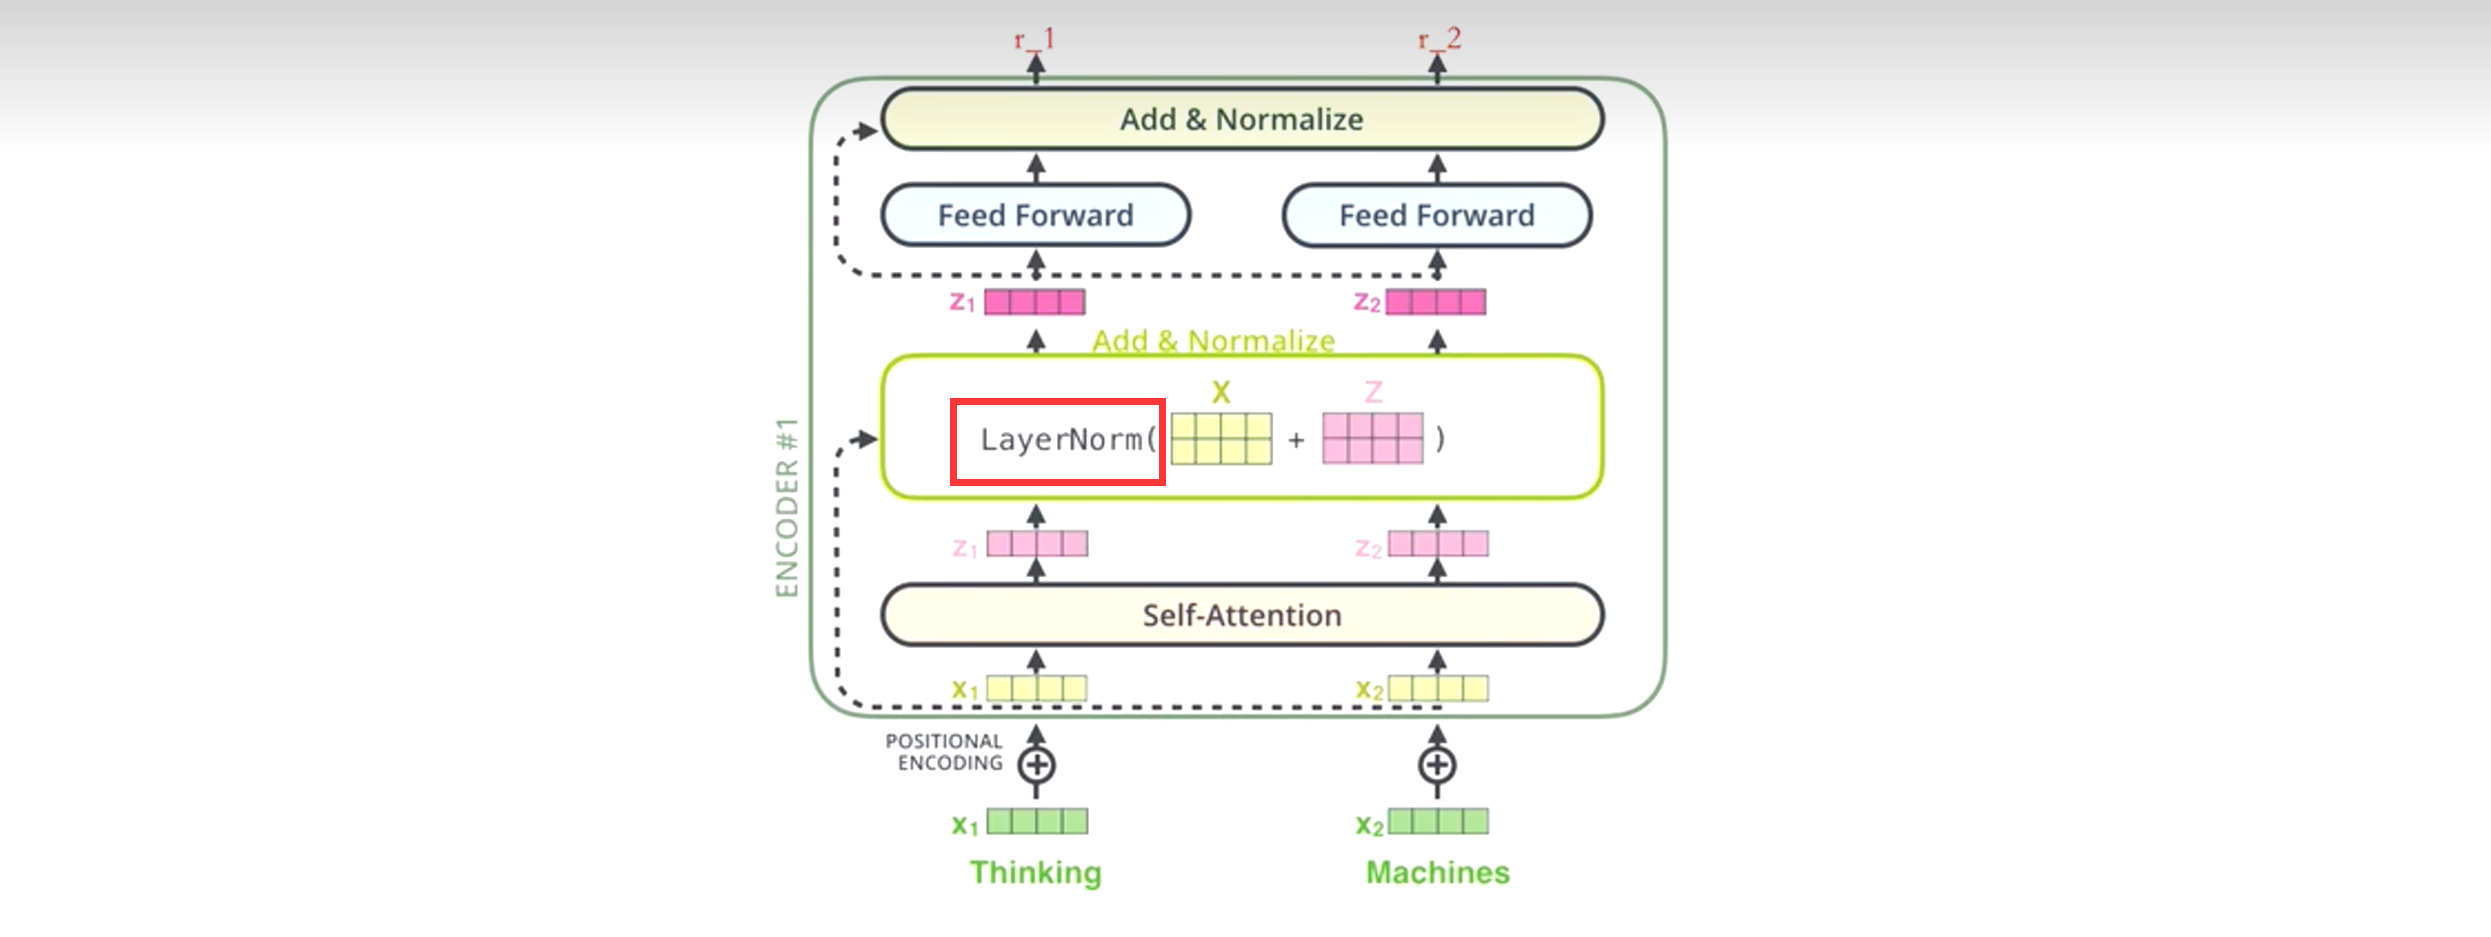
首先由一个Norm函数，Norm里面做残差，输入是X和谈粉色的Z1，输出是深粉色的Z1
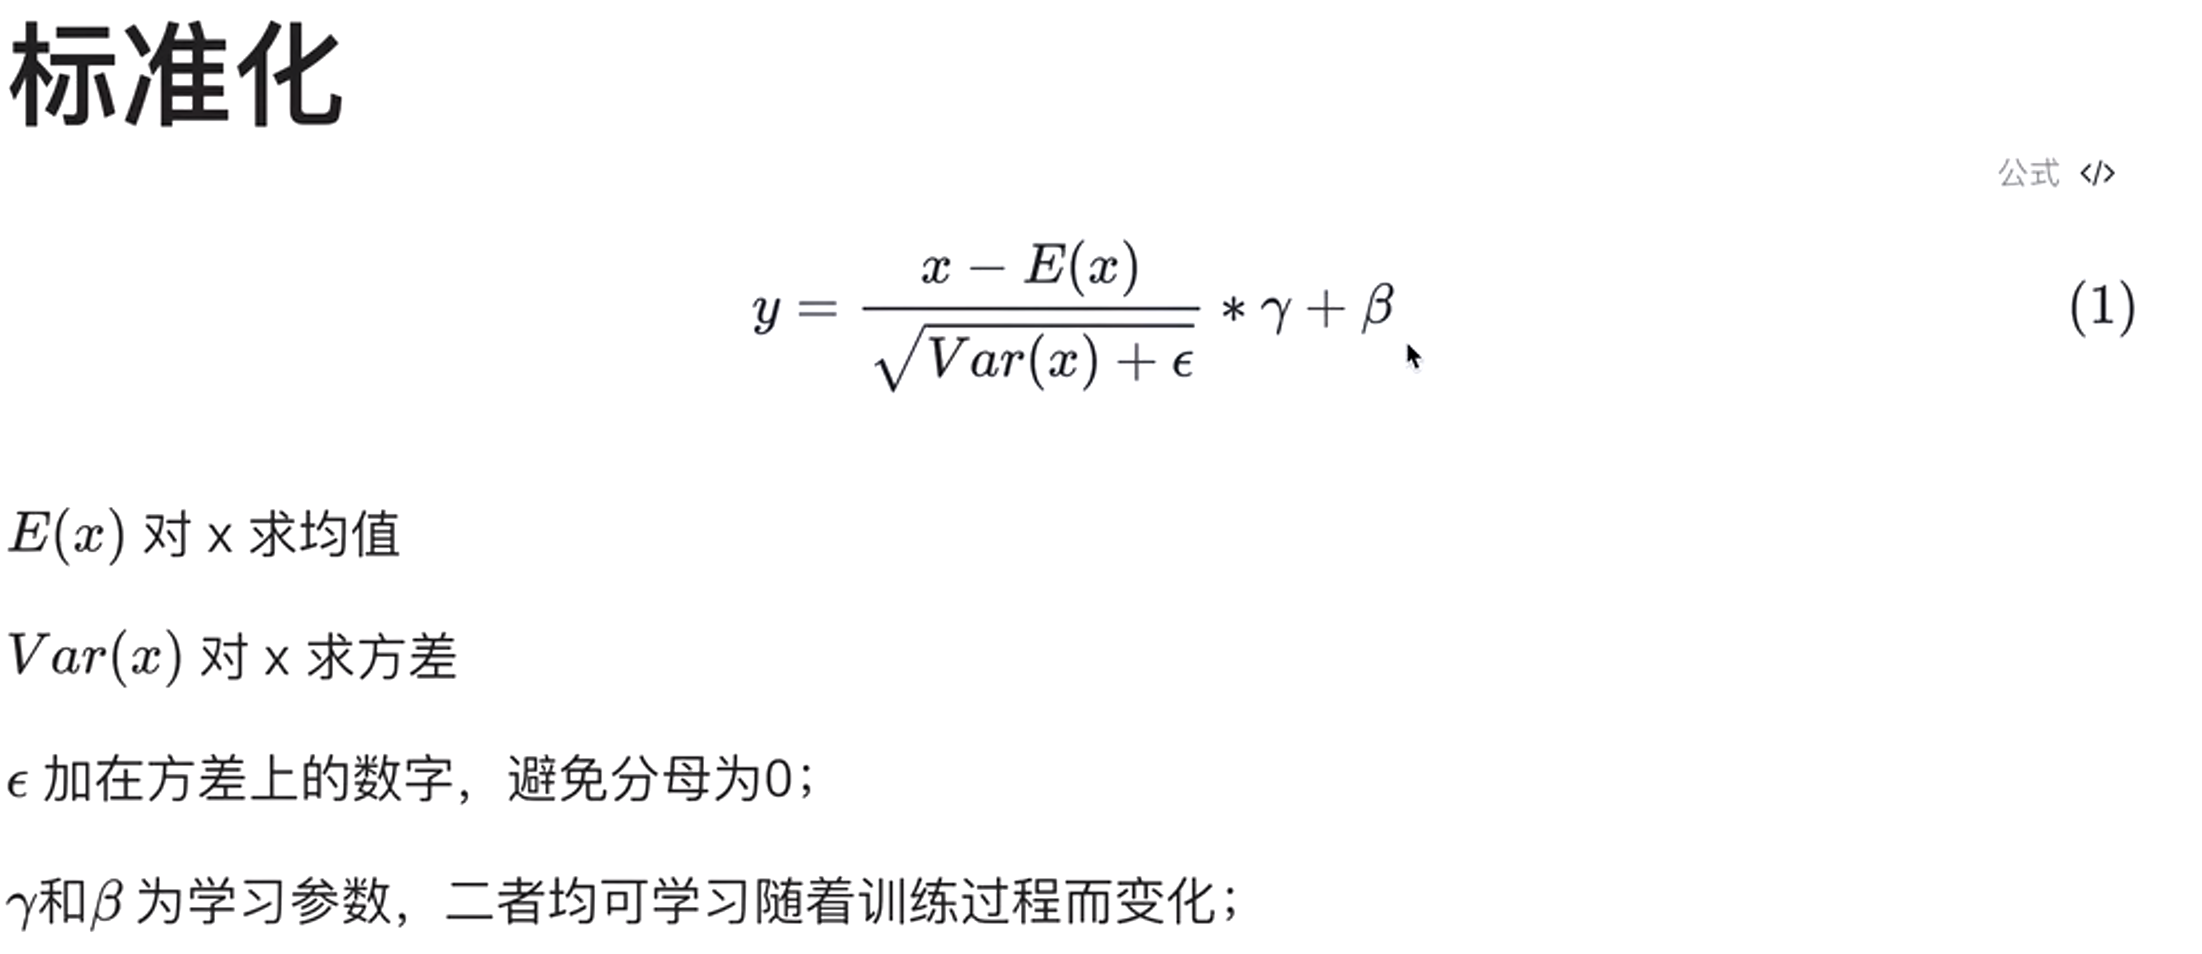

In [6]:
import copy
import math
from collections import namedtuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class LayerNorm(nn.Module):
    def __init__(self, feature, eps=1e-6):
        super(LayerNorm, self).__init__()
        #feature 就是self-attention的x大小
        #eps就是防止分母为0
        self.a_2 = nn.Parameter(torch.ones(feature))
        self.b_2 = nn.Parameter(torch.zeros(feature))
        self.eps = eps

    def forward(self, x):
        # keepdim:如果将其设置为True，则表示函数在计算平均值和标准差时会保持输入张量的维度。
        # -1表示最后一维
        mean = x.mean(-1, keeddim = True)
        std = x.std(-1, keepdim = True)
        #输出结果参照标准化的公式
        return self.a_2*(x - mean) / (std + self.eps) +self.b_2
    


In [6]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout = 0.1):
        super(SublayerConnection, self).__init__()
        #第一步做layernorm
        self.layer_norm = LayerNorm(size)
        #第二步做Dropout
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, x, sublayer):
        #X就是self-attention的输入
        #sublayer就是slef.attention的层
        #俩者就构成一个残差链接
        return self.dropout(self.layer_norm(x + sublayer(x)))    

## attention 构建

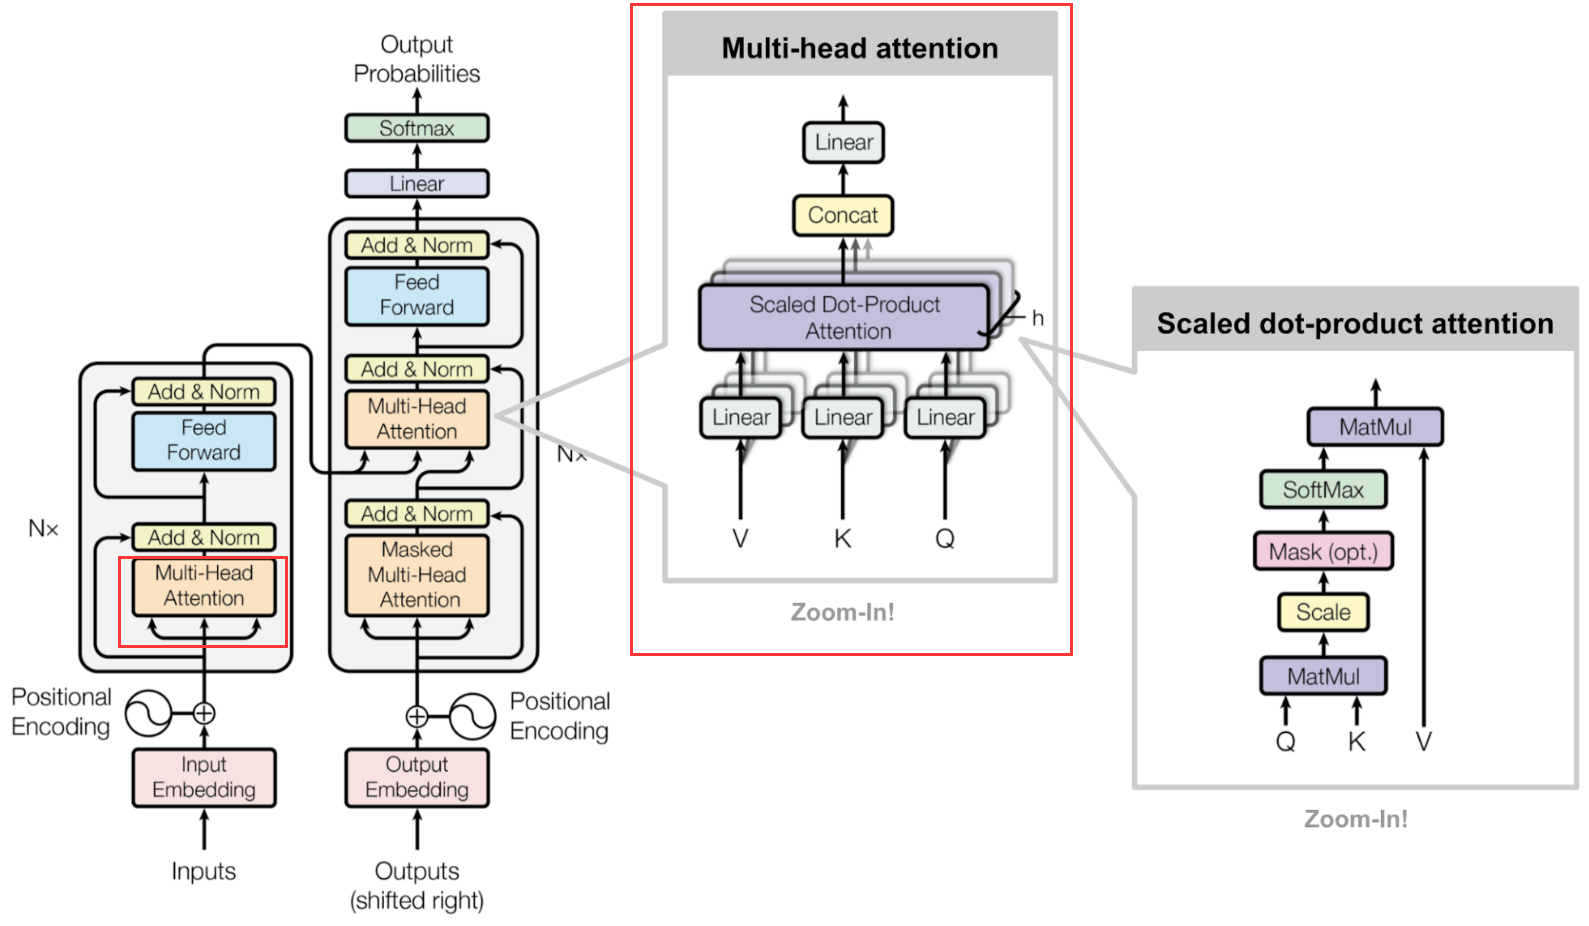

In [7]:
def self_attention(query, key, value, dropout = None, mask = None):
    d_k = query.size(-1)
    #首先计算QK相乘，然后除以d_k的平方根，再进行softmax操作
    #-2表示倒数第二维，-1表示倒数第一维，transpose就是转置
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # mask的操作在QK之后再Softmax之前
    if mask is not None:
        mask.cuda()
        scores = scores.mask_fill(mask == 0, -1e9)
    self_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        self_attn = dropout(self_attn)
    #最后计算QKV相乘
    return torch.matmul(self_attn, value), self_attn

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()

    def forward(self, head, d_model, query, value, key, dropout = 0.1, mask = None):
        #d_model 就是输入的维度 head 就是头的个数默认是8
        assert(d_model % head == 0)
        self.d_k =d_model // head
        self.head = head
        self.d_model = d_model
        #对输入的查询张量query进行线性变换，这个变换通常使用一个可训练的权重矩阵实现。
        self.linear_quary = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_valie = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p = dropout)
        self.attn = None
        if mask is not None:
            mask = mask.unsqueeze(1)
        #多头需要对X进行拆分 query==key==value
        n_batch = query.size(0)
        #view(n_batch, -1, head, self.d_k) 将线性变换的输出重塑为一个4维张量，其维度为(n_batch, seq_len, head, d_k)，
        # 其中n_batch是批大小，seq_len是输入序列的长度，head是注意力头数，d_k是用于计算注意力的键和查询的维数。
        # -1，PyTorch会自动计算该维度的大小，以保持张量元素数量不变。
        query = self.linear_query(query).view(n_batch, -1, self.head, self.d_k).transpose(1, 2)
        key = self.linear_key(key).view(n_batch, -1, self.head, self.d_k).transpose(1, 2)
        value = self.linear_value(value).view(n_batch, -1, self.head, self.d_k).transpose(1, 2)
        x, self.attn = self_attention(query, key, value, dropout = self.dropout, mask = mask)
        x = x.transpose(1, 2).contiguous().view(n_batch, -1, self.head * self.d_k)
        return self.linear_out(x)


## 位置编码的构建
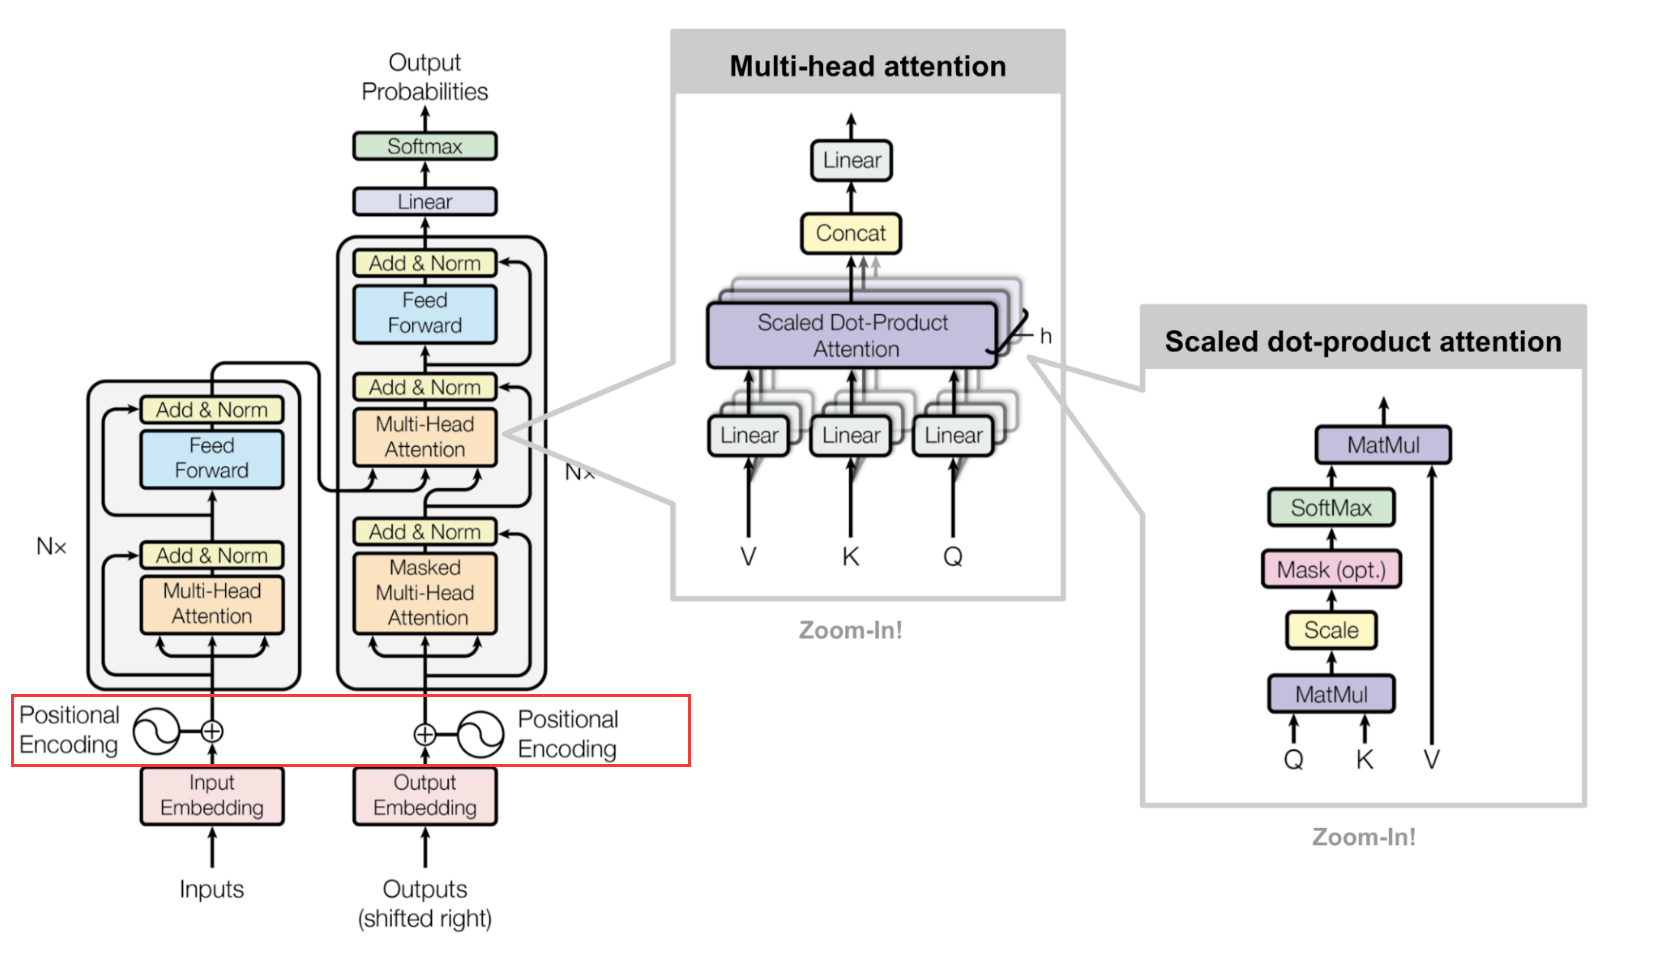
也就是如何区分“你爱我”和“我爱你”，如果不使用位置编码，在经过词向量化后再模型里认为它俩是一样的文字，但是实际上是不同的，“我”和“你”的不同位置表达的意思并相同
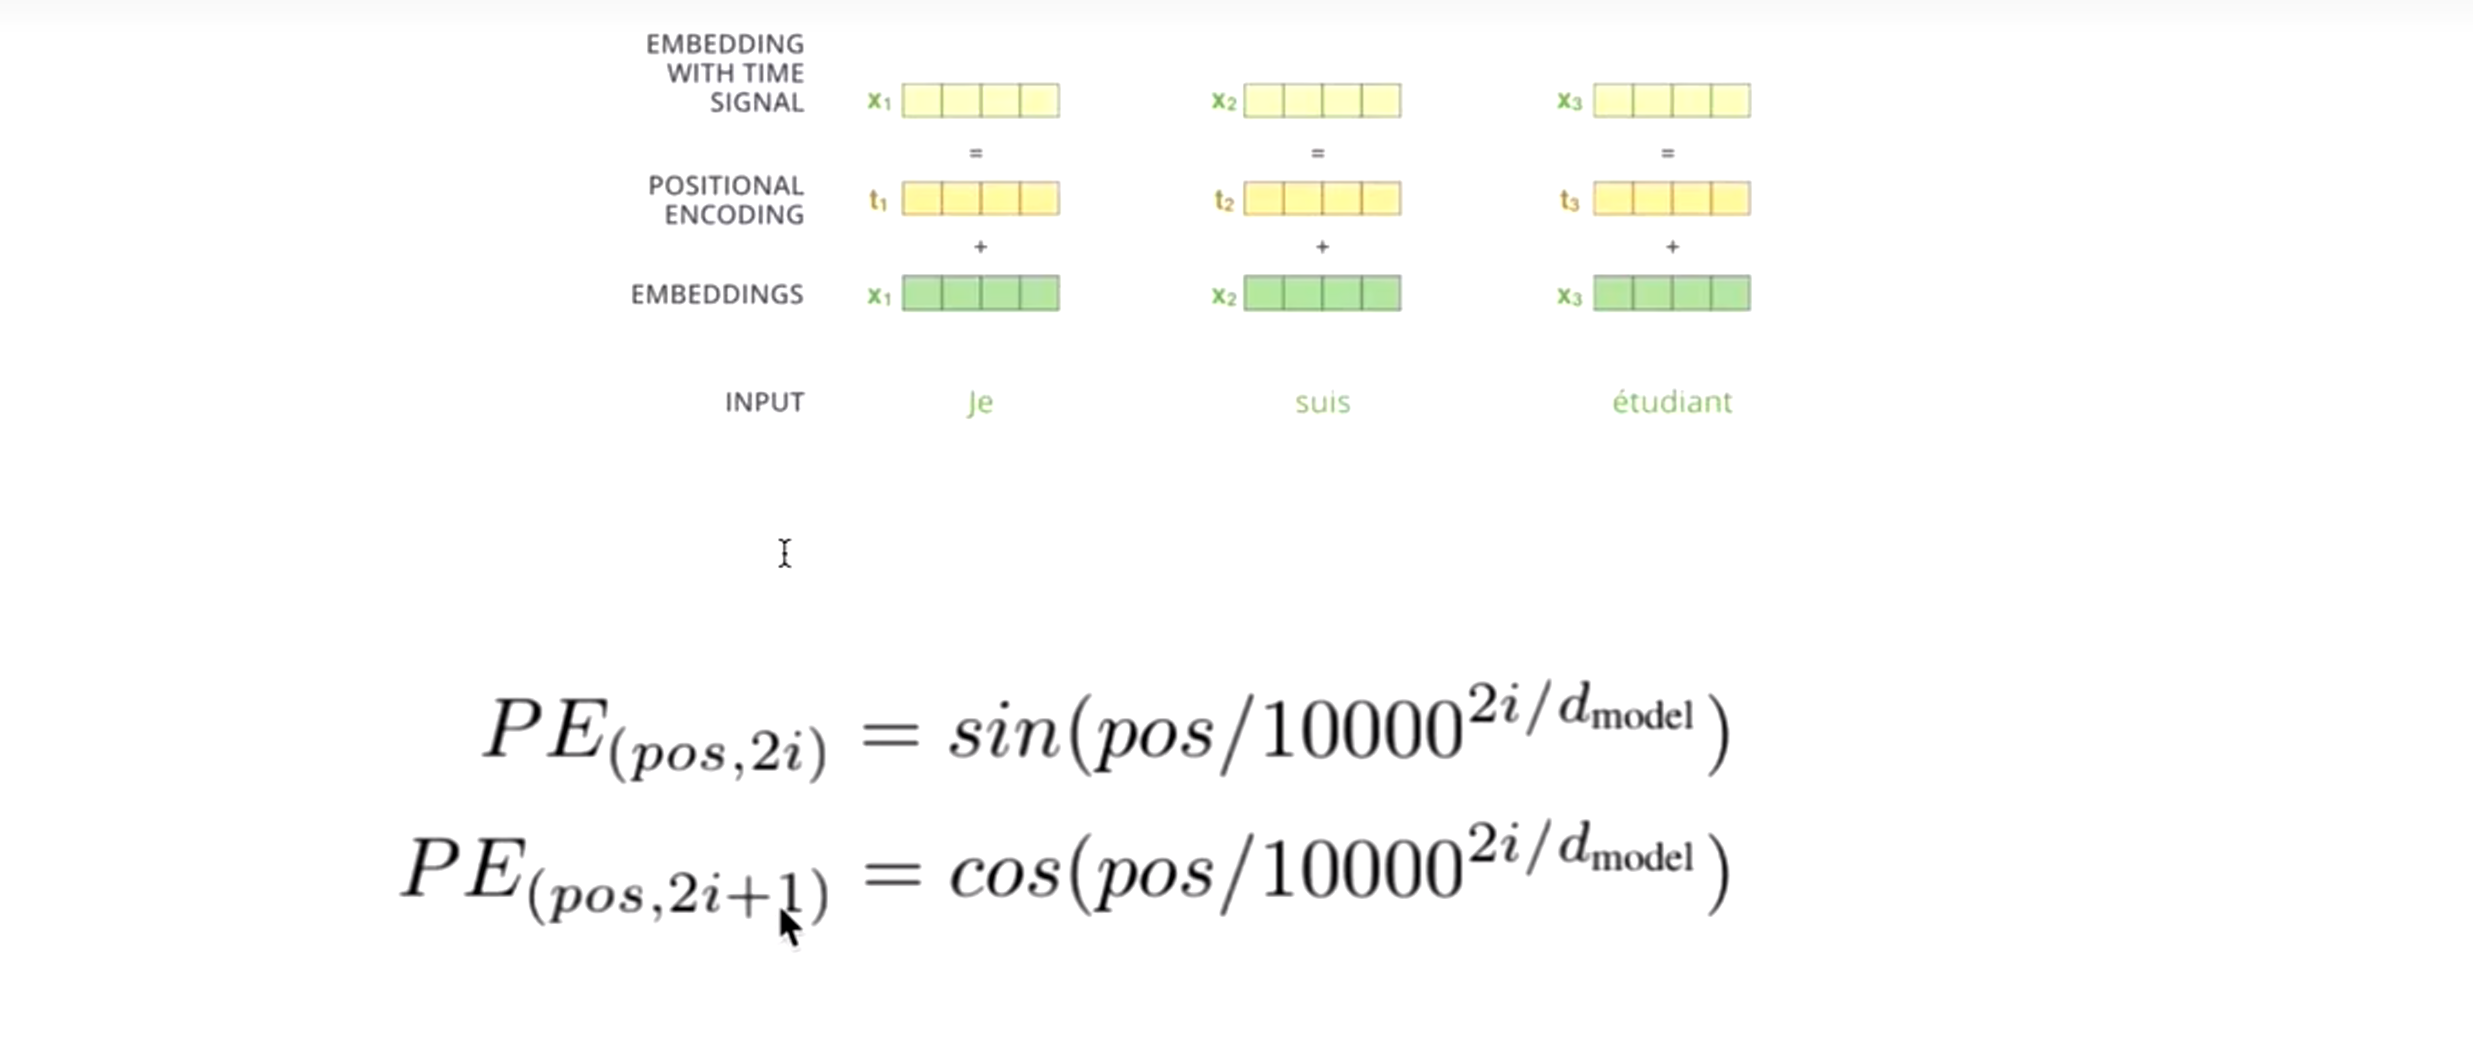

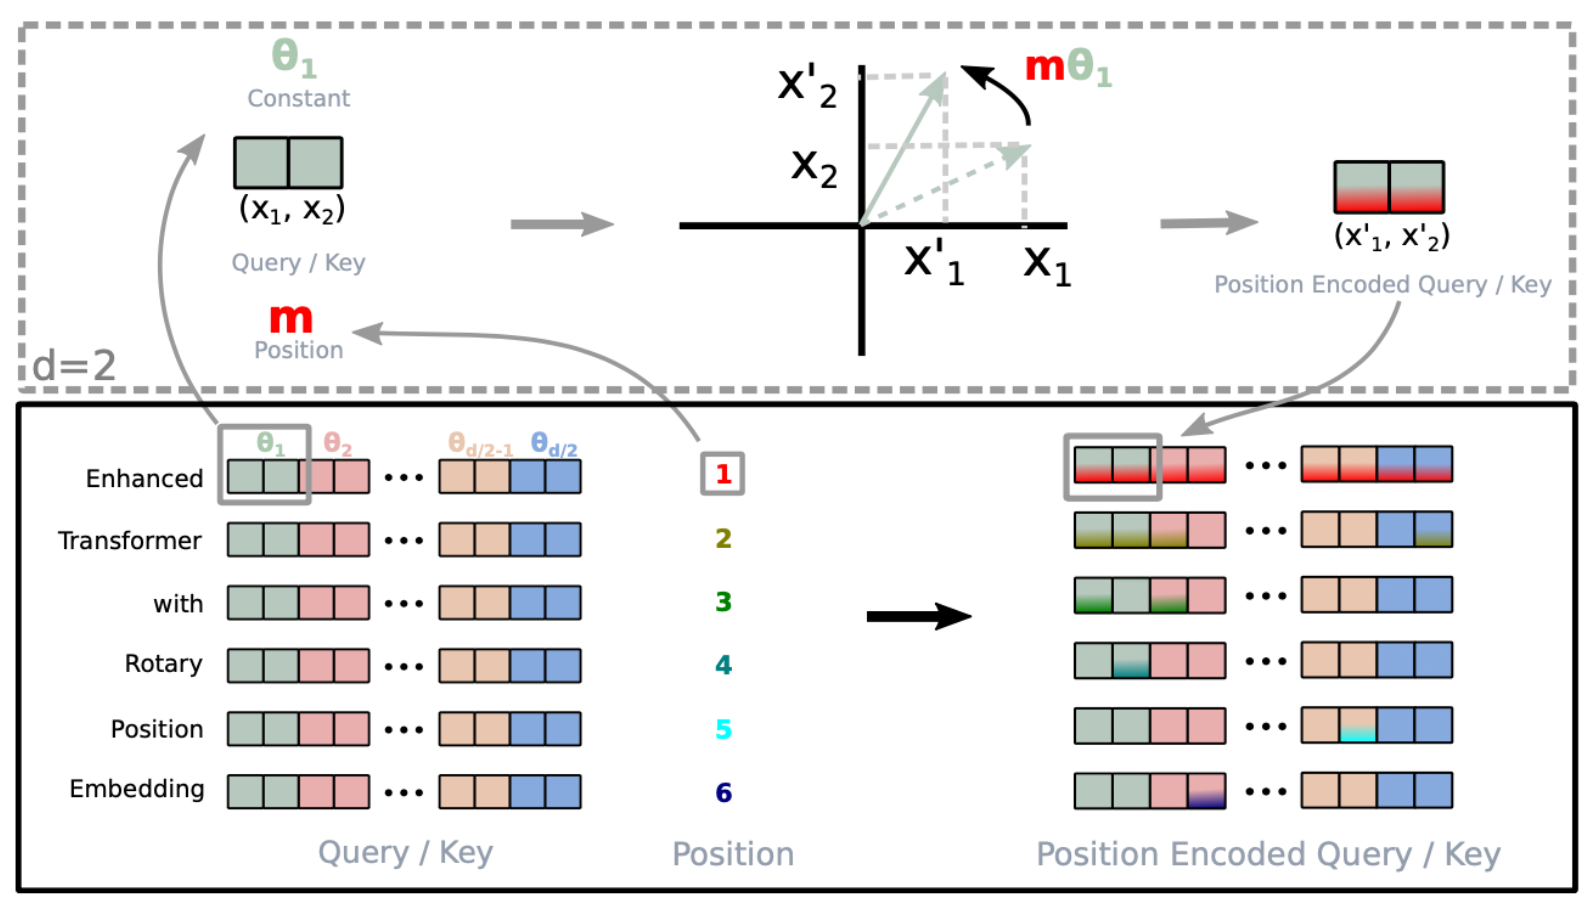


In [11]:
class PositionEncoding(nn.Module):
    def __init__(self, dim, dropout, max_len = 5000):
        super(PositionEncoding, self).__init__()
        #因为位置编码需要成双成对的的出现，所以必须判断一下维度是否为偶数维度
        if dim % 2 !=0 :
            raise ValueError("Cannot use sin/cos positional encoding with "
                             "odd dim (got dim = {:d})".format(dim))
        """
        构建位置编码的公式为
        PE(pos, 2i/2i+1) = sin/cos(pos/10000^{2i/d_model})
        """
        # max_len代表解码器生成句子最长的长度，如果是对“我爱你”精心位置编码，那么max_len就等于3
        pe = torch.zeros(max_len, dim)
        #torch.arange(0, max_len)将创建一个一维张量，包含从0到max_len-1的整数序列。
        #然后，.unsqueeze(1)将该张量从一维张量转换为列向量。这个张量的形状为(max_len, 1)，其中每行包含一个从0到max_len-1的整数。
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, dim, 2, dtype = torch.float) *
                              -(math.log(10000.0) / dim )))
        #pe[:, 0::2]就是对位置编码矩阵的第一个维度进行切片，取出其中索引为偶数的位置。
        pe[:, 0 :: 2] = torch.sin(position.float() * div_term)
        pe[:, 1 :: 2] = torch.cos(position.float() * div_term)
        """
        pe 是位置编码矩阵，形状为 (max_len, d_model)，其中 max_len 表示序列的最大长度，d_model 表示嵌入向量的维度。
        pe.unsqueeze(1) 的作用是在 pe 张量的第 1 个维度上增加一个新的维度，生成一个新的张量，形状为 (max_len, 1, d_model)，可以用于和输入张量 x 进行相加。
        """
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
        self.drop_out = nn.Dropout(p = dropout)
        self.dim =dim

    def forward(self, emb, step= None):
        #乘上维度的开平方，为了避免在多头注意力中出现梯度消失的问题。
        emb = emb * math.sqrt(self.dim)
        """
        如果 step 为 None，则表示处理的是整个序列，这时将 self.pe 的前 emb.size(0) 行加到 emb 中，
        保证位置编码张量的长度与输入张量的长度一致。
        如果 step 不为 None，则表示处理的是序列中的一个时间步，这时将 self.pe 中的第 step 行加到 emb 中。
        """
        if step in None:
            emb = emb +self.pe[:emb.size(0)]
        else: 
            emb = emb + self.pe[step]
        emb = self.dropout(emb)
        return emb      

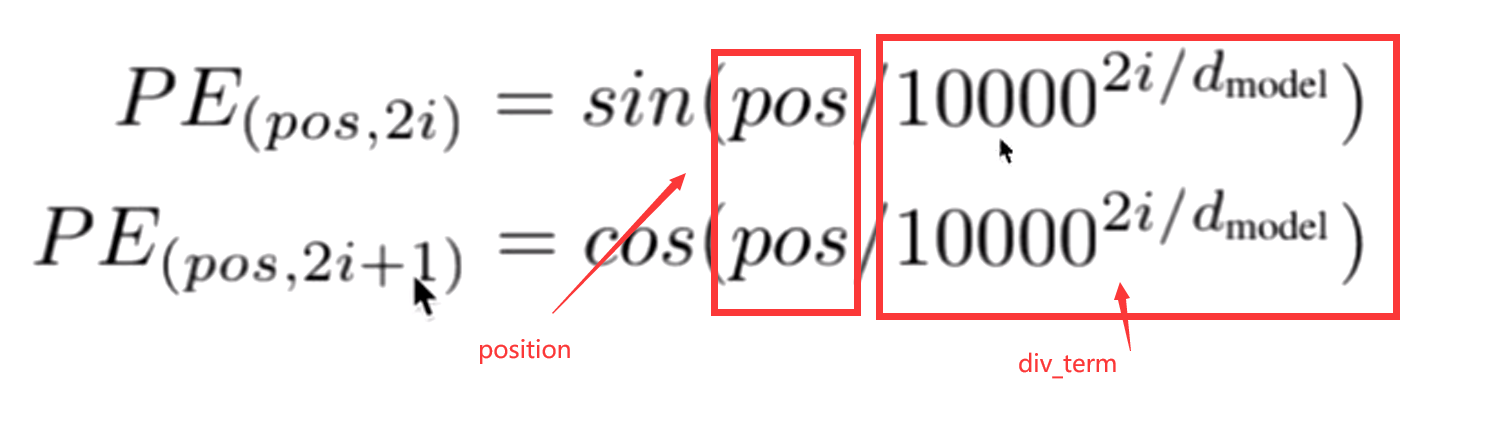

## 前馈神经网络层
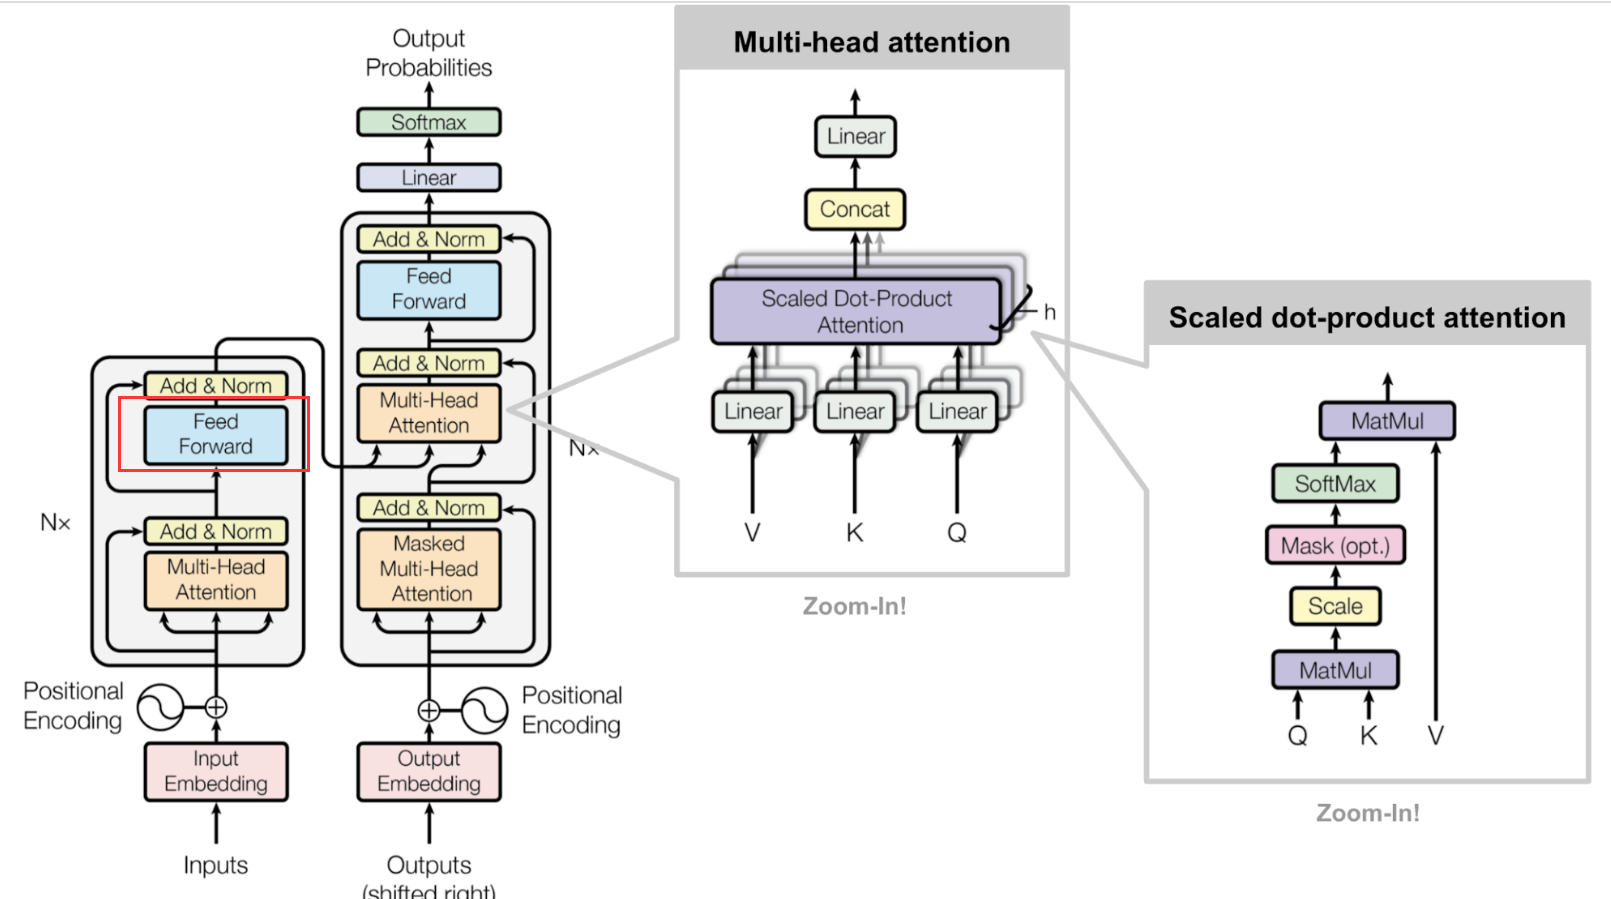

In [12]:
class PositionWiseFeedForward(nn.Module):
    #FeedForward架构  w2(relu(w1+b1)) + b2
    """
    d_ff 的值应该在创建 PositionWiseFeedForward 实例时被设置。
    在这个实例中，d_model 是前一层的输入维度，d_ff 是隐藏层维度，dropout 参数是 dropout 层的置信度。
    """
    def __init__(self, d_model, d_ff, dropout = 0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model, eps = 1e-6)
        self.dropout_1 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dropout_2  = nn.Dropout(dropout)
    """
    在 forward 方法中，模块首先将输入 x 传递给 dropout_1 层，得到 inter。
    然后，inter 被传递给 w_2 线性层，得到最终的输出。最后，输出被返回并用于后续的模型训练或预测。"""
    def forward(self, x):
        inter = self. dropout_1(self.relu(self.w_1))
        output = self.dropout_2(self.w_2(inter))
        return output

## mask-mutilattention
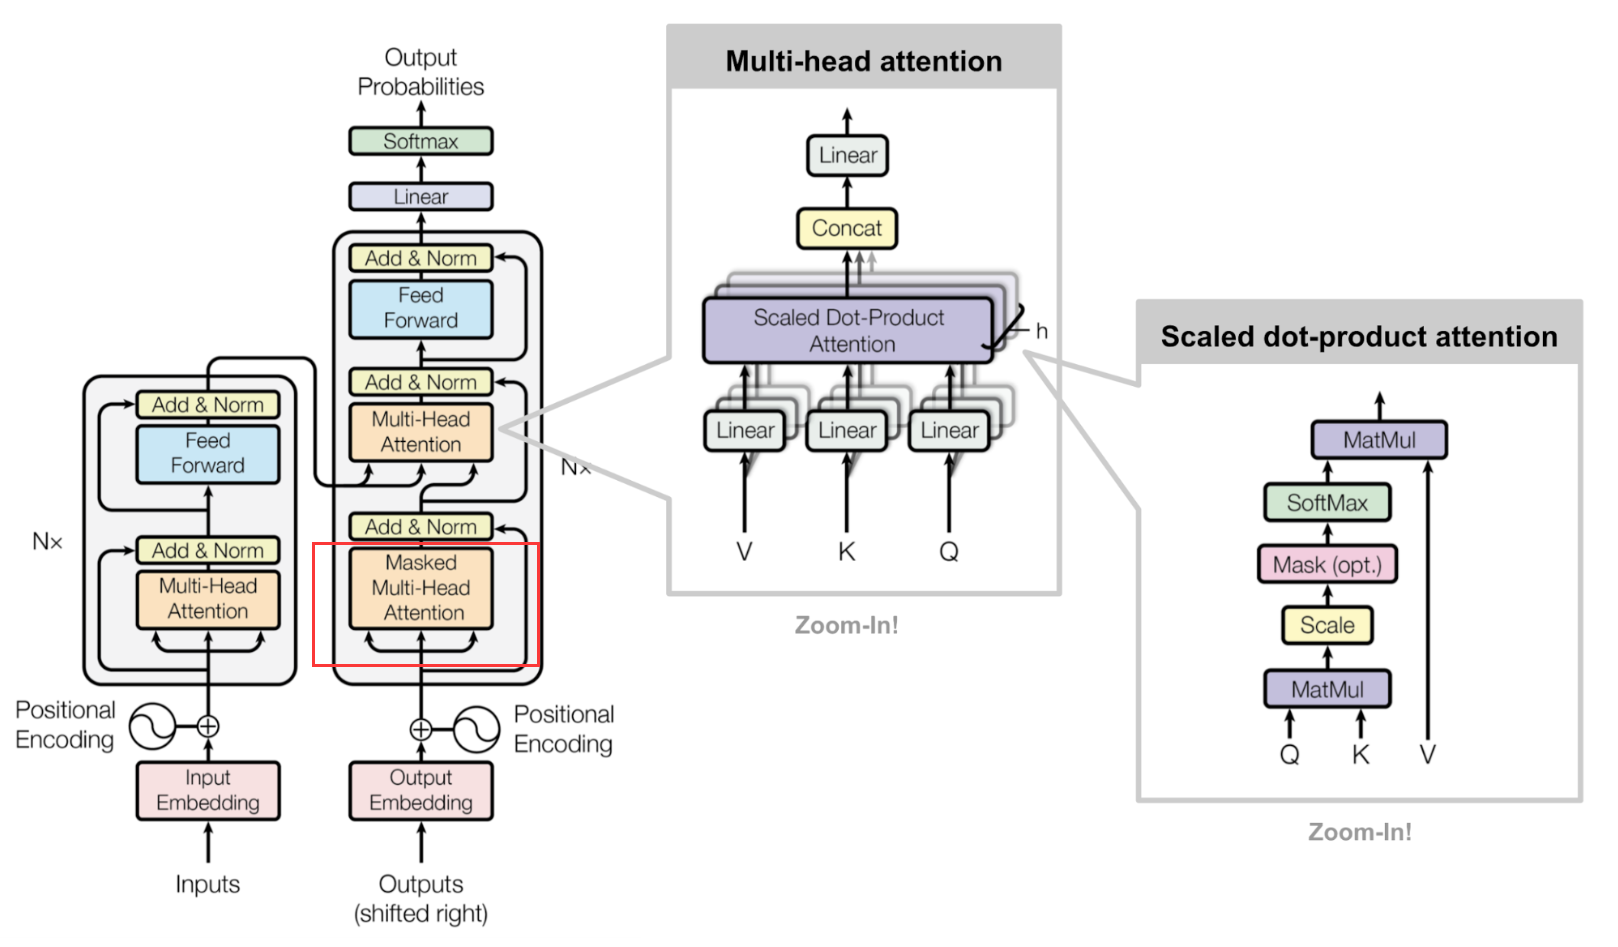

In [5]:
def pad_mask(src, r2l_trg, trg, pad_idx):
    if isinstance(src, tuple):
        if len(src) == 4:
            src_image_mask = (src[0][:, :, 0] != pad_idx).unsqueeze(1)
            src_motion_mask = (src[1][:, :, 0] != pad_idx).unsqueeze(1)
            src_object_mask = (src[2][:, :, 0] != pad_idx).unsqueeze(1)
            src_rel_mask = (src[3][:, :, 0] != pad_idx).unsqueeze(1)
            enc_src_mask = (src_image_mask, src_motion_mask, src_object_mask, src_rel_mask)
            dec_src_mask_1 = src_image_mask & src_motion_mask
            dec_src_mask_2 = src_image_mask & src_motion_mask & src_object_mask & src_rel_mask
            dec_src_mask = (dec_src_mask_1, dec_src_mask_2)
            src_mask = (enc_src_mask, dec_src_mask)
        if len(src) == 3:
            src_image_mask = (src[0][:, :, 0] != pad_idx).unsqueeze(1)
            src_motion_mask = (src[1][:, :, 0] != pad_idx).unsqueeze(1)
            src_object_mask = (src[2][:, :, 0] != pad_idx).unsqueeze(1)
            enc_src_mask = (src_image_mask, src_motion_mask, src_object_mask)
            dec_src_mask = src_image_mask & src_motion_mask
            src_mask = (enc_src_mask, dec_src_mask)
        if len(src) == 2:
            src_image_mask = (src[0][:, :, 0] != pad_idx).unsqueeze(1)
            src_motion_mask = (src[1][:, :, 0] != pad_idx).unsqueeze(1)
            enc_src_mask = (src_image_mask, src_motion_mask)
            dec_src_mask = src_image_mask & src_motion_mask
            src_mask = (enc_src_mask, dec_src_mask)
    else:
        src_mask = (src[:, :, 0] != pad_idx).unsqueeze(1)
    if trg is not None:
        if isinstance(src_mask, tuple):
            trg_mask = (trg != pad_idx).unsqueeze(1) & subsequent_mask(trg.size(1)).type_as(src_image_mask.data)
            r2l_pad_mask = (r2l_trg != pad_idx).unsqueeze(1).type_as(src_image_mask.data)
            r2l_trg_mask = r2l_pad_mask & subsequent_mask(r2l_trg.size(1)).type_as(src_image_mask.data)
            return src_mask, r2l_pad_mask, r2l_trg_mask, trg_mask
        else:
            trg_mask = (trg != pad_idx).unsqueeze(1) & subsequent_mask(trg.size(1)).type_as(src_mask.data)
            r2l_pad_mask = (r2l_trg != pad_idx).unsqueeze(1).type_as(src_mask.data)
            r2l_trg_mask = r2l_pad_mask & subsequent_mask(r2l_trg.size(1)).type_as(src_mask.data)
            return src_mask, r2l_pad_mask, r2l_trg_mask, trg_mask  # src_mask[batch, 1, lens]  trg_mask[batch, 1, lens]

    else:
        return src_mask

def subsequent_mask(size):
    #用于生成一个用于注意力加权的掩码

    """
    首先定义了一个名为 attn_shape 的参数，它是一个形状为 (1, size, size) 的张量，其中 size 是一个常数，
    表示掩码中的元素应该取值 1 还是 0。接下来，函数使用 numpy 的 np.triu 函数生成一个三行三列的矩阵，
    这个矩阵的所有非对角线上的元素都是 1。这个矩阵被转化为 uint8 类型，以便在 PyTorch 中进行处理。
    """
    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k = 1).astyper('uint8')
    """
    from_numpy 函数将 numpy 数组转换为 PyTorch 张量，并使用 == 0 运算符进行布尔运算，生成一个表示掩码是否为 0 的 PyTorch 张量。
    这个张量被用于将输入张量与注意力加权张量进行拼接，以生成最终的输出张量。
    """
    return (torch.from_numpy(mask) == 0).cuda()

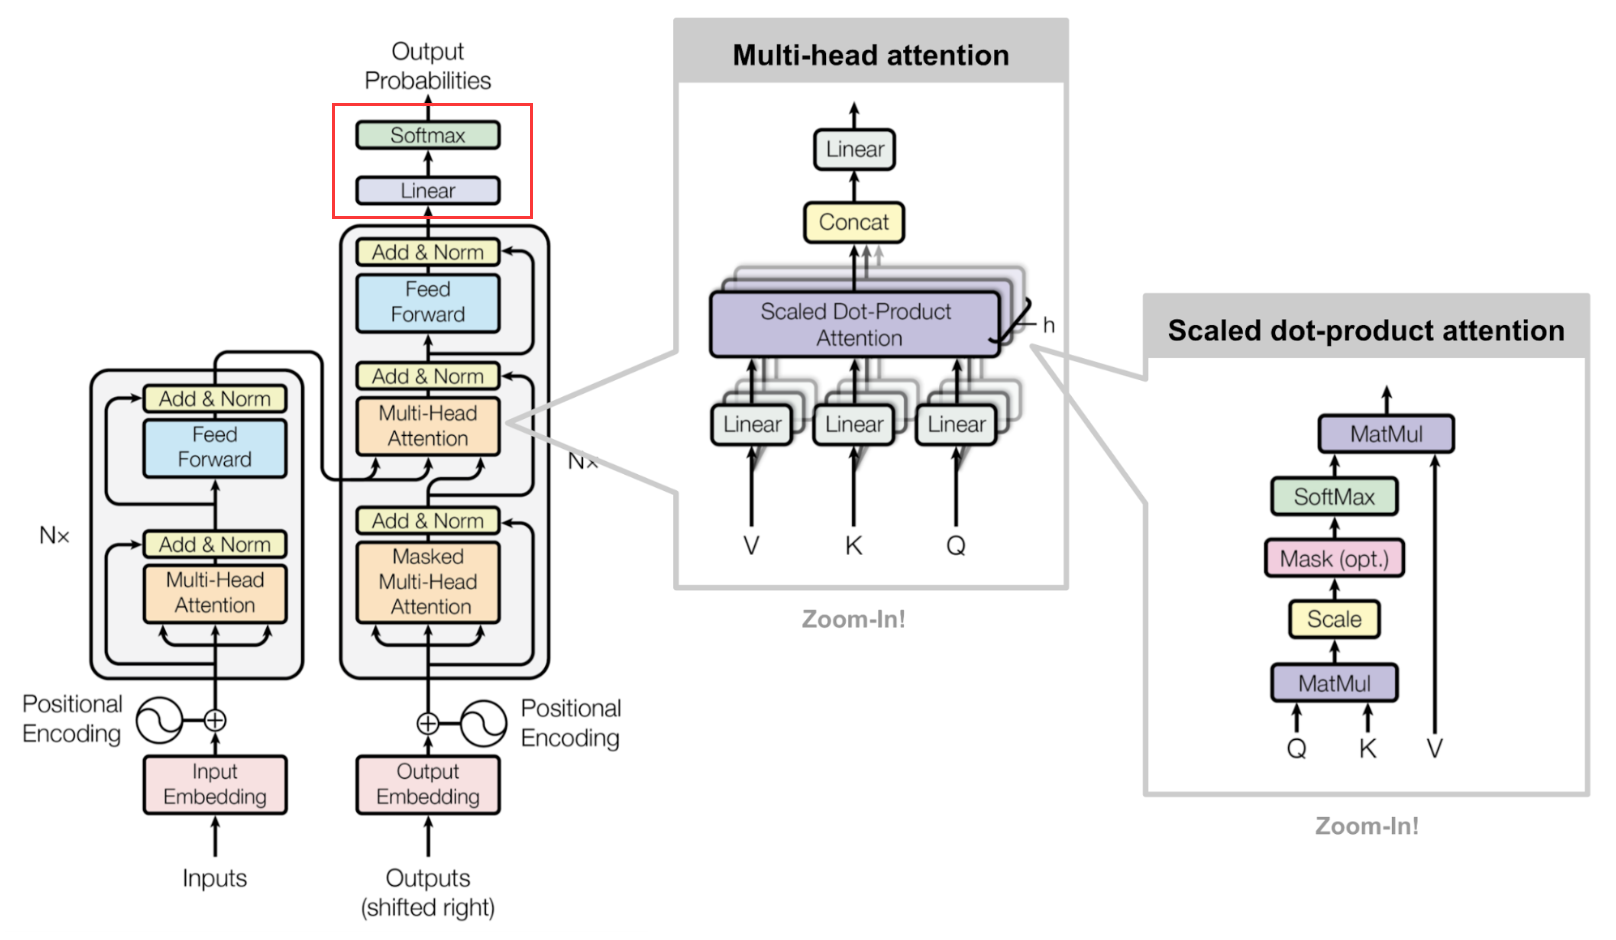

In [3]:

class Generator(nn.Module):
     def __init__(self, d_model, vocab_size):
          super(Generator, self).__init__()
          self.linear = nn.Linear(d_model, vocab_size)

     def forward(self, x):
          return  F.log_softmax(self.linear(x), abc = 1, dim = -1)
          

## 构建Encoder
### 构建单层Encoderlayer
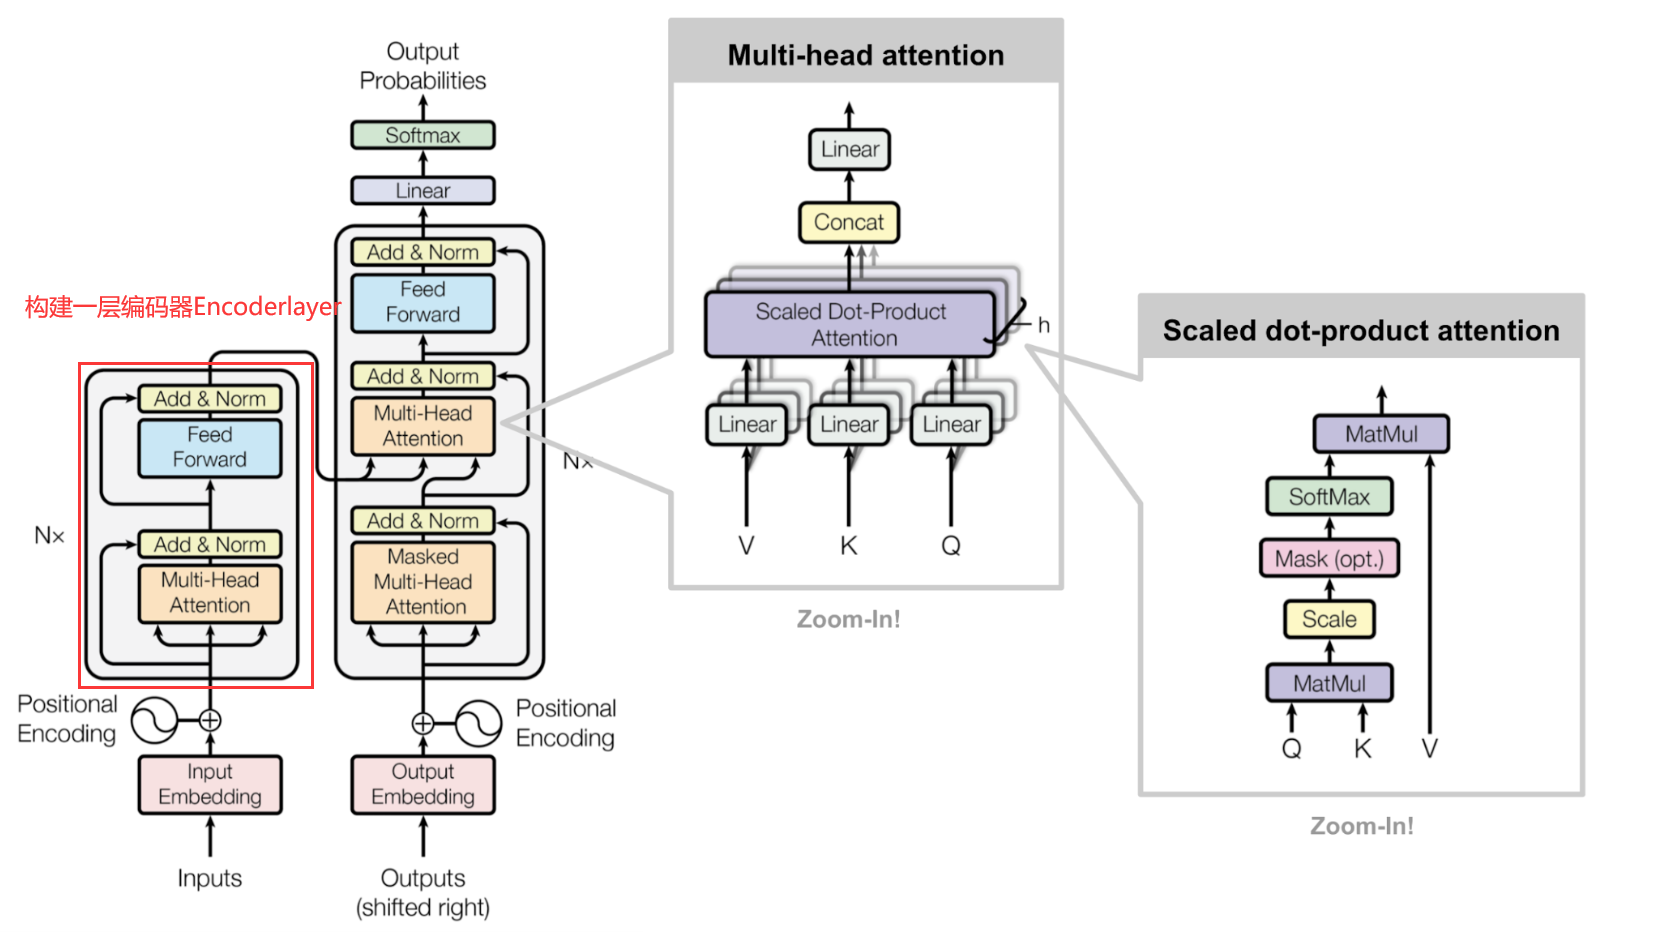

In [7]:
def clones(module, n):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(n)])
#构建一层编码器
class EncoderLayer(nn.Module):
    attn = MultiHeadAttention(n_haead, d_model, dropout)
    def __init__(self, size, attn, feed_forward, dropout = 0.1):
        super(EncoderLayer, self).__init__()
        self.attn = attn
        self.feed_forward = feed_forward
        # clones 函数将一个 module 和一个整数 n 作为参数。它返回一个 ModuleList，其中包含 n 个 module 的深层副本。
        self.sublayer_connection = clones(SublayerConnection(size, dropout), 2)
    
    def forward(self, x, mask):
        x= self.sublayer_connection[0](x, lambda x: self.attn(x, x, x, mask))
        return self.sublayer_connection[1](x, self.feed_forward)

#构建n层编码器
class Encoder(nn.Module):
    def __init__(self, n, encoder_layer):
        super(Encoder, self).__init__()
        self.encoder_layer = clones(encoder_layer, n)

    
    def forward(self, x, src_mask):
        for layer in self.encoder_layer:
            x = layer(x, src_mask)
        return x        